In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

scipy version: 1.2.1


In [3]:
import json

import corner
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import astropy.units as u

from thejoker.data import RVData
from thejoker.sampler import TheJoker, JokerParams

In [4]:
# Stellar parameters
with open(base_dir + "mass_radius.json", "r") as f:
    data = json.load(f)
    mass_radius_mu = np.array(data["mean"])
    mass_radius_cov = np.array(data["cov"])

In [5]:
df = pd.read_csv("../../data/harps_rvs.csv")
for k in df.columns:
    new_k = k.strip("#").strip()
    if new_k != k:
        df[new_k] = df[k]
        del df[k]

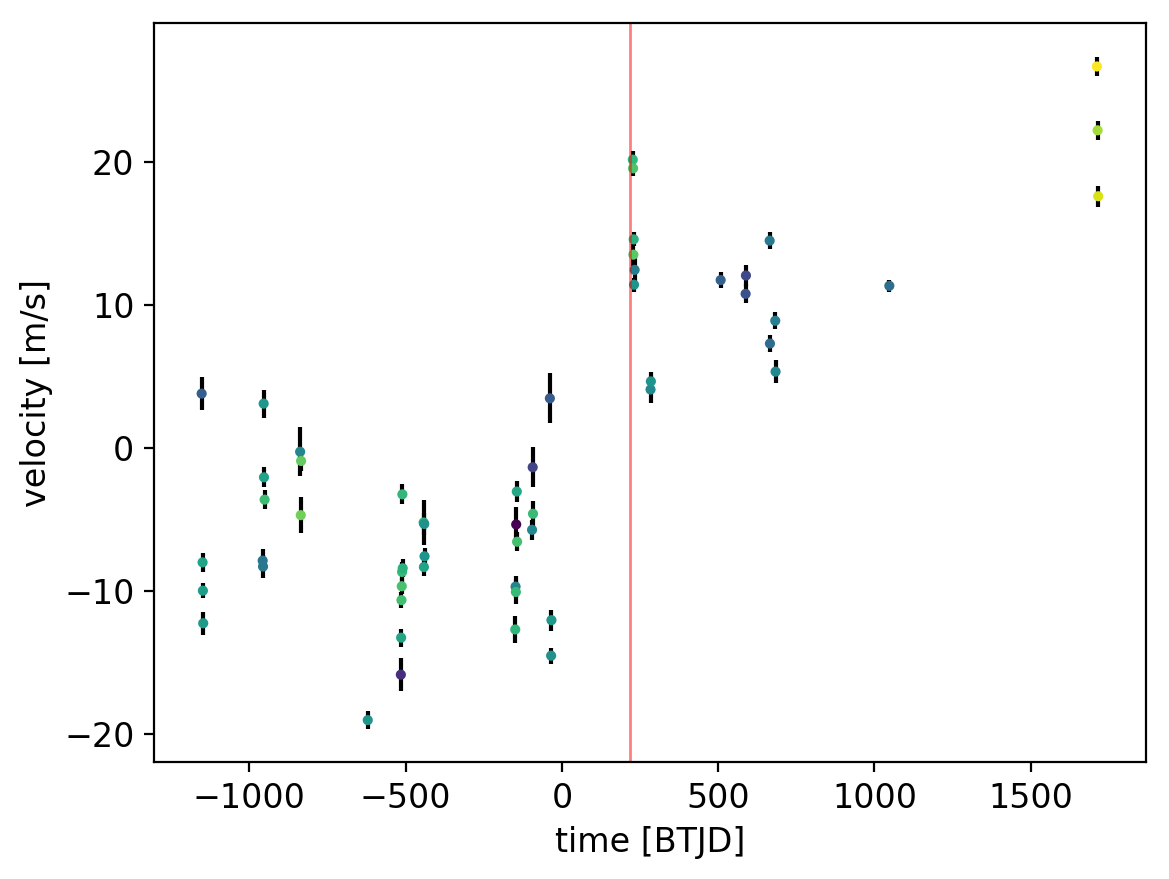

In [6]:
BTJD_ref = 2457000
HARPS_upgrade = 2457218.5 # July 2015

# Remove one bisector outlier
df = df[df.bis < df.bis.max()]
        
df = df.sort_values("date")

x_rv = np.ascontiguousarray(df.bjd - BTJD_ref, dtype=np.float64)
HARPS_upgrade -= BTJD_ref
pug = np.ascontiguousarray(x_rv >= HARPS_upgrade, dtype=bool) # stands for post-upgrade, obviously
y_rv = np.ascontiguousarray(df.rv - df.rv.mean(), dtype=np.float64)
yerr_rv = np.ascontiguousarray(df.e_rv, dtype=np.float64)
#bis_rv = np.ascontiguousarray((df.bis - df.bis.mean()) / df.bis.std(), dtype=np.float64)
#fwhm_rv = np.ascontiguousarray((df.fwhm - df.fwhm.mean()) / df.fwhm.std(), dtype=np.float64)
bis_rv = np.ascontiguousarray(df.bis, dtype=np.float64)
fwhm_rv = np.ascontiguousarray(df.fwhm, dtype=np.float64)
shk = np.ascontiguousarray(df.s_hk, dtype=np.float64)
yerr_shk = np.ascontiguousarray(df.e_s_hk, dtype=np.float64)



t = np.linspace(x_rv.min()-5, x_rv.max()+5, 1000)

plt.errorbar(x_rv, y_rv, yerr=yerr_rv, fmt=",k", zorder=-10)
plt.scatter(x_rv, y_rv, c=shk, s=7)
plt.axvline(HARPS_upgrade, c='r', alpha=0.5, lw=1)
plt.xlabel("time [BTJD]")
plt.ylabel("velocity [m/s]");

##### to start with, we will neglect some model components:
- post-upgrade RV offset is assumed to be fixed and perfectly-known
- RV-FWHM correlation is not used

In [7]:
y_rv_guess = np.copy(y_rv)
y_rv_guess[pug] -= 15.4

In [8]:
data = RVData(t=x_rv, rv=y_rv_guess*u.m/u.s, stddev=yerr_rv*u.m/u.s)

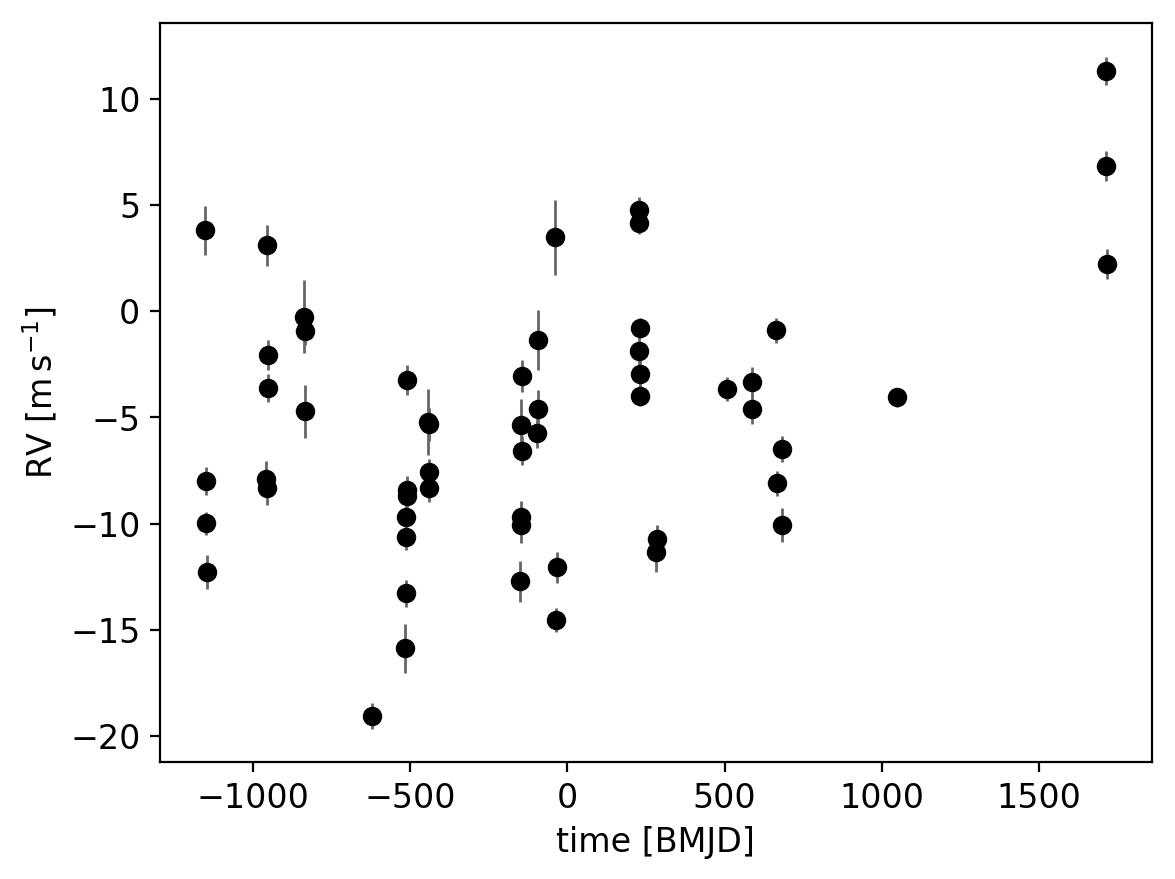

In [9]:
_ = data.plot()

#### get some starting guess parameters for the polynomial trend:

In [10]:
xs = data.t.value
ys = data.rv.value
ivars = data.ivar.value

def design_matrix(P):
    A = np.zeros((len(x_rv),5))
    A[:,0] = xs**2
    A[:,1] = xs
    A[:,2] = np.ones_like(xs)
    A[:,3] = np.sin(2*np.pi / P * xs)
    A[:,4] = np.cos(2*np.pi / P * xs)
    return A

def loglike(A, param):
    resids = ys - np.dot(A,param)
    return -0.5 * np.sum(resids**2 * ivars)

def best_param(A, cov=True):
    # returns the optimized parameters for a given design matrix A
    # if cov, return a tuple (best_param, cov)
    ATA = np.dot(A.T, ivars[:, None] * A)
    ATy = np.dot(A.T, ivars * ys)
    soln = np.linalg.solve(ATA, ATy)
    if cov:
        return soln, cov
    return soln

In [11]:
A = design_matrix(17.47)
soln, cov = best_param(A)

In [12]:
soln

array([ 2.68815314e-06,  1.96677610e-03, -7.20410900e+00, -9.48600220e-01,
        2.49620909e+00])

In [13]:
soln_K = np.sqrt(soln[3]**2 + soln[4]**2)
soln_K

2.6703749178240352

In [14]:
params = JokerParams(P_min=10*u.day, P_max=25*u.day,
                     poly_trend=3,
                     linear_par_mu=np.array([soln_K, soln[2], soln[1], soln[0]]),
                     linear_par_Lambda=np.diag([1e1, 1e1, 1e-2, 1e-5]) ** 2,
                     #jitter=1.*u.m/u.s)
                     jitter=(1., 2.), jitter_unit=u.m/u.s)
# linear parameters are: semi-amplitude, RV offset, linear RV trend, quadratic RV trend (in that order I hope!!!)
joker = TheJoker(params)

In [15]:
prior_samples = joker.sample_prior(size=1_000_000)

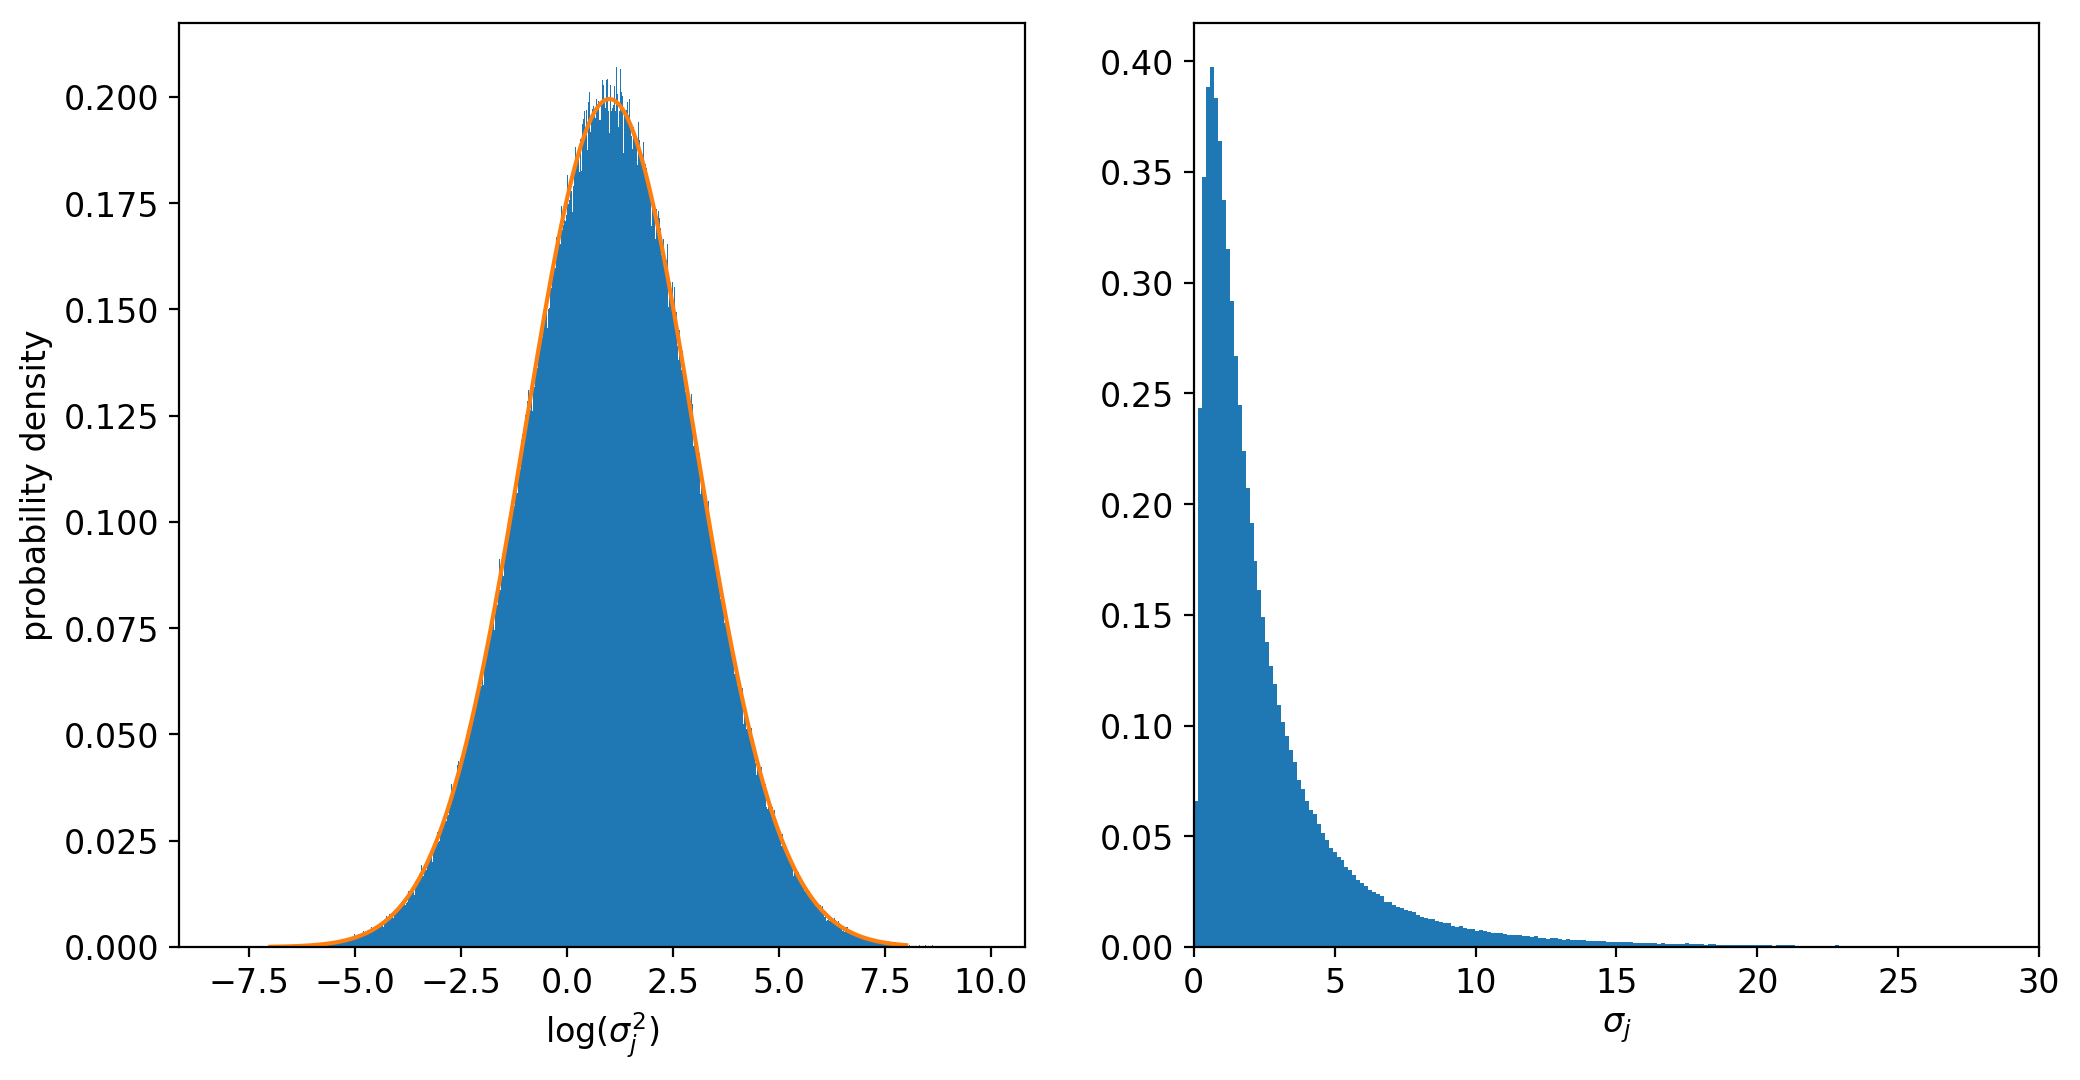

In [16]:
fig,(ax1,ax2) = plt.subplots(1, 2, figsize=(12,6))
ax1.hist(np.log(prior_samples['jitter'].value)*2., bins=1000, density=True)
xx = np.linspace(-7,8,1000)
mu, sig = 1., 2.
yy = np.exp(-(xx-mu)**2 / (2 * sig**2)) / np.sqrt(2*np.pi*sig**2)
ax1.plot(xx, yy)
ax1.set_xlabel(r'log($\sigma_j^2$)')
ax1.set_ylabel('probability density')
ax2.hist(prior_samples['jitter'].value, bins=1000, density=True)
ax2.set_xlim([0.,30.])
ax2.set_xlabel(r'$\sigma_j$');

In [20]:
samples = joker.rejection_sample(data, n_prior_samples=int(1e6))

INFO: 8 good samples after rejection sampling [thejoker.sampler.sampler]


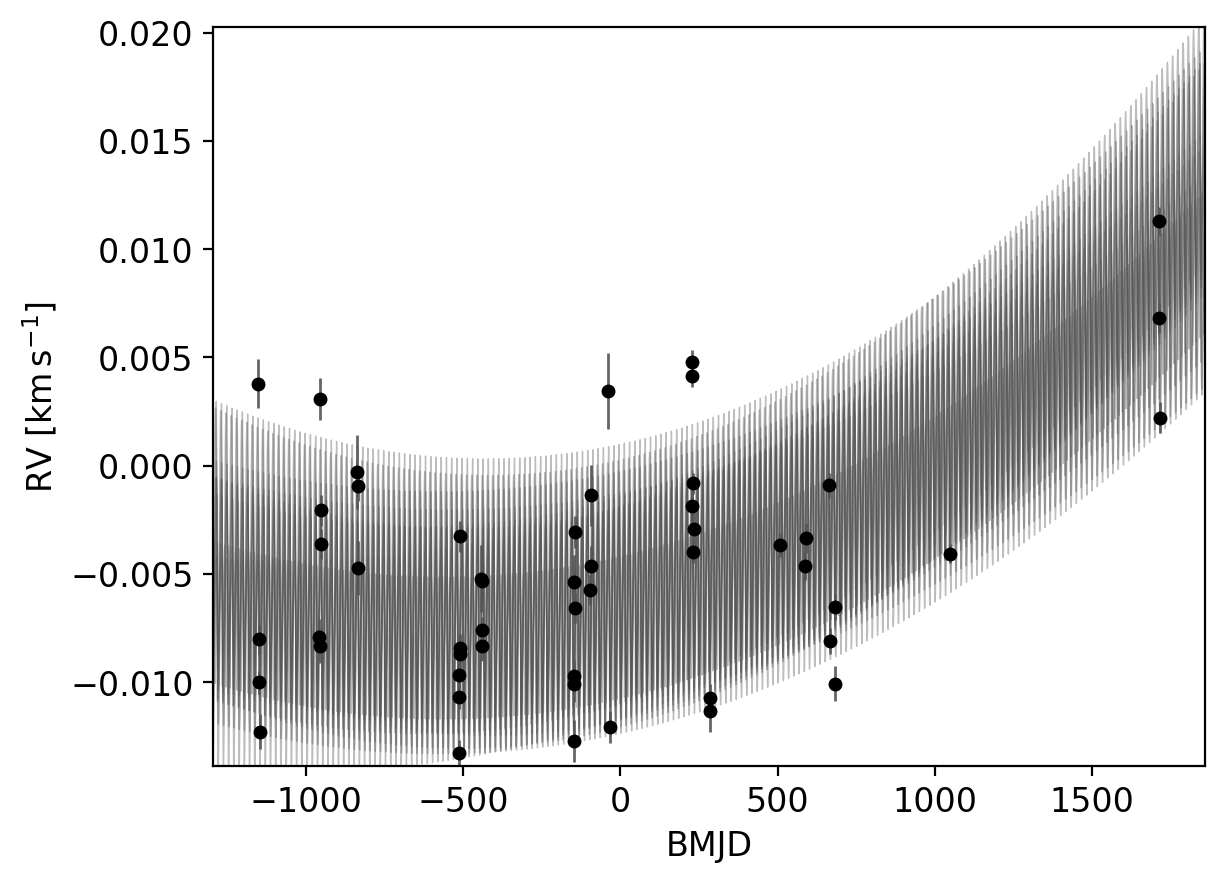

In [21]:
from thejoker.plot import plot_rv_curves
_ = plot_rv_curves(samples, data=data)

In [22]:
samples

JokerSamples([('P',
               <Quantity [16.62967627, 16.63284523, 16.63413572, 11.73335539, 16.64075892,
                          16.64154001, 16.64608658, 16.6321597 ] d>),
              ('M0',
               <Quantity [1.76045438, 1.02367823, 1.98150795, 1.55931127, 0.4848724 ,
                          1.15762752, 1.15222431, 1.6659515 ] rad>),
              ('e',
               <Quantity [0.25634316, 0.60879223, 0.1251172 , 0.35247111, 0.34451739,
                          0.2228532 , 0.41076954, 0.23914973]>),
              ('omega',
               <Quantity [2.24921573, 1.49779882, 2.86919318, 2.32597813, 0.959758  ,
                          1.38199166, 1.59716735, 2.27025572] rad>),
              ('jitter',
               <Quantity [3.52975968, 3.37554264, 4.2345509 , 3.9929848 , 3.60227931,
                          3.63005826, 3.9284932 , 3.53104201] m / s>),
              ('K',
               <Quantity [4.90794147, 4.78153504, 6.00746751, 3.27406777, 5.72579144,
     

In [37]:
# copy-pasta'd from adrn/hq
def plot_phase_fold(data, sample, ax=None, label=True,
                    jitter_errorbar=True, orbit_style=None):

    if ax is None:
        ax = plt.gca()
    fig = ax.figure

    if len(sample) > 1:
        #sample = max_likelihood_sample(data, sample)
        raise ValueError('Can only pass one sample.')

    if orbit_style is None:
        orbit_style = dict()
    orbit_style.setdefault('color', 'tab:blue')
    orbit_style.setdefault('zorder', -1)

    P = sample['P']
    M0 = sample['M0']
    orbit = sample.get_orbit(0)

    # HACK:
    trend = orbit._vtrend
    orbit._vtrend = lambda t: 0
    rv = data.rv - trend(data.t)

    t0 = data.t0 + (P/(2*np.pi)*M0).to(u.day, u.dimensionless_angles())
    phase = data.phase(P=P, t0=t0)

    # plot the phase-folded data and orbit
    rv_unit = u.km/u.s
    ax.errorbar(phase, rv.to(rv_unit).value,
                data.stddev.to(rv_unit).value,
                linestyle='none', marker='o', color='k', markersize=5,
                zorder=10)

    if jitter_errorbar and 'jitter' in sample:
        ax.errorbar(phase, rv.to(rv_unit).value,
                    np.sqrt(data.stddev**2 +
                            sample['jitter']**2).to(rv_unit).value,
                    linestyle='none', marker='', elinewidth=0., color='#aaaaaa',
                    alpha=0.9, capsize=3, capthick=1, zorder=9)

    phase_grid = np.linspace(0, 1, 1024)
    ax.plot(phase_grid, orbit.radial_velocity(t0 + phase_grid*P),
            marker='', **orbit_style)

    if label:
        ax.set_xlabel(r'phase, $\frac{M-M_0}{2\pi}$')
        ax.set_ylabel('RV [{0:latex_inline}]'.format(rv_unit))

    return fig

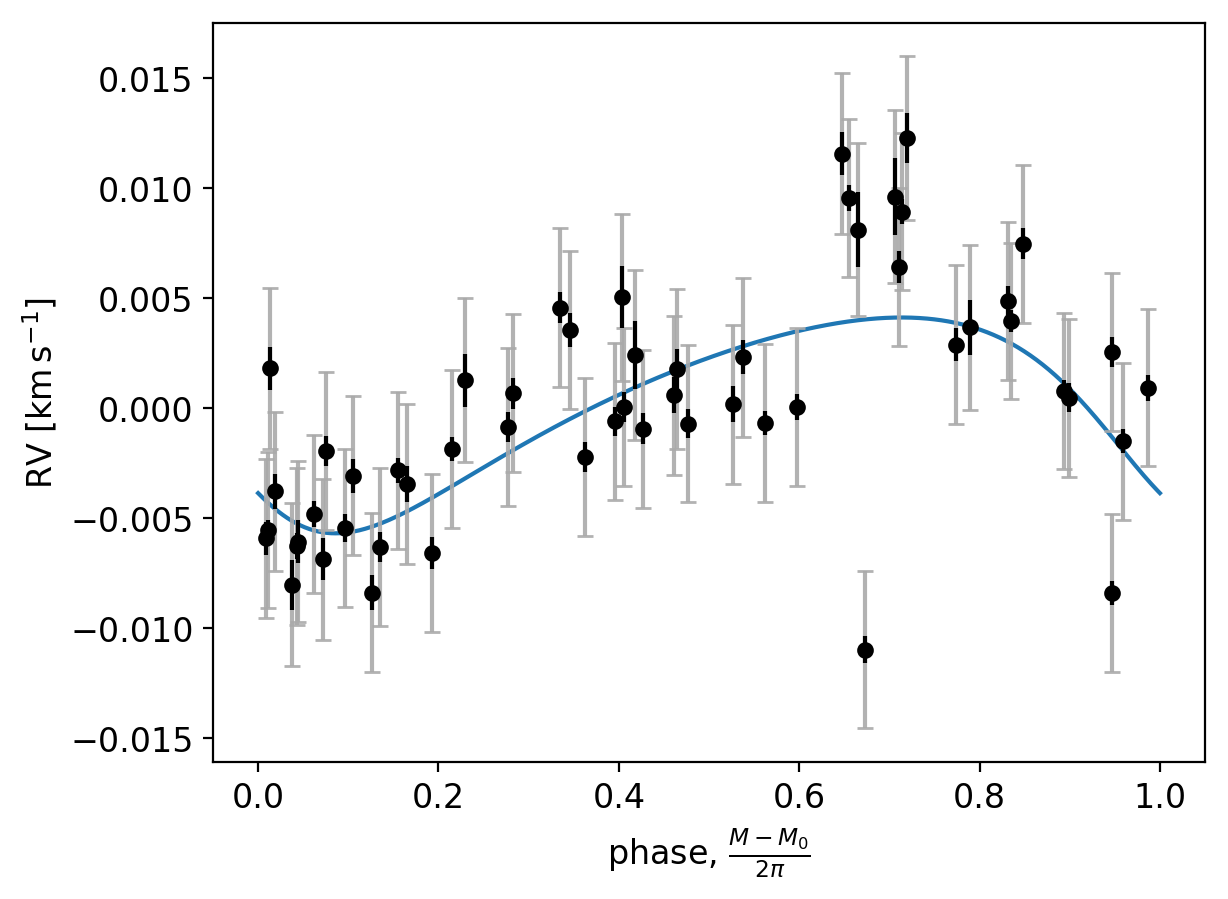

In [38]:
_ = plot_phase_fold(data, samples[0])